In [1]:
import pandas as pd
import numpy as np

# 读取数据
df = pd.read_csv('customer_churn_flag.csv')

# 查看基本信息
print(df.info())
print(df.head())
# 选取用于建模的特征
features = ["Frequency", "Monetary", "Recency_Days"]
X = df[features]

# 目标变量
y = df["is_churned"]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_smote, y_train_smote)
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Customer_Name    325 non-null    object 
 1   Last_Order_Date  325 non-null    object 
 2   Frequency        325 non-null    int64  
 3   Monetary         325 non-null    float64
 4   Recency_Days     325 non-null    int64  
 5   Churn            325 non-null    int64  
 6   is_churned       325 non-null    int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 17.9+ KB
None
                   Customer_Name Last_Order_Date  Frequency  Monetary  \
0         399 Vietnamese Kitchen       5/28/2025          6     313.5   
1                       A-1 Plus       7/23/2024          4     346.0   
2  American Paper and Provisions       4/24/2023          1       0.0   
3             And Destroy Coffee        7/7/2025          5    1659.4   
4                        Avi Cue        2/5/2024 

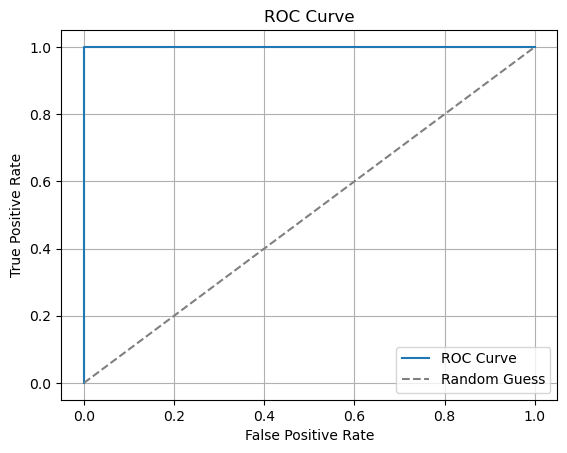

AUC 分数: 1.0


In [2]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 预测的概率（不是标签）
y_proba = model.predict_proba(X_test)[:, 1]  # 取“流失”的概率

# 计算 ROC 曲线数据
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# 画 ROC 曲线
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], linestyle="--", color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# 计算 AUC 分数
auc_score = roc_auc_score(y_test, y_proba)
print("AUC 分数:", round(auc_score, 4))


In [3]:
# 从原数据里取几位客户模拟“未来会不会流失”
sample_df = df.sample(5, random_state=42)
X_sample = sample_df[["Frequency", "Monetary", "Recency_Days"]]
X_sample_scaled = scaler.transform(X_sample)
sample_pred = model.predict(X_sample_scaled)
sample_proba = model.predict_proba(X_sample_scaled)[:, 1]

sample_df["预测流失"] = sample_pred
sample_df["流失概率"] = sample_proba
display(sample_df)


,Customer_Name,Last_Order_Date,Frequency,Monetary,Recency_Days,Churn,is_churned,预测流失,流失概率
234,Parakeet Juicery - Del Mar,7/11/2025,65,4882.96,2,0,0,0,0.072614
110,Gingergrass Mini Mart,7/10/2023,3,151.48,734,1,1,1,0.999999
248,Proof Bakery,7/8/2025,41,3496.63,5,0,0,0,0.080064
9,Bacetti,3/25/2025,3,-13.24,110,1,1,1,0.500371
93,Friends & Family Pizza Co,10/17/2024,8,309.95,269,1,1,1,0.973109


In [4]:
# ========== 预测新数据：predict.csv ==========

# 读取新数据（只包含 Frequency / Monetary / Recency_Days）
predict_df = pd.read_csv("predict.csv")

# 标准化特征（注意：使用和训练模型同一个 scaler）
X_new = predict_df[["Frequency", "Monetary", "Recency_Days"]]
X_new_scaled = scaler.transform(X_new)

# 进行预测
y_new_pred = model.predict(X_new_scaled)
y_new_proba = model.predict_proba(X_new_scaled)[:, 1]

# 添加结果列
predict_df["预测流失"] = y_new_pred
predict_df["流失概率"] = y_new_proba

# 手动设定更敏感的阈值，比如 0.1（预测为流失的要求更宽松）
custom_threshold = 0.1

# 加一列新预测字段
predict_df["预测流失_阈值0.1"] = (predict_df["流失概率"] >= custom_threshold).astype(int)

# 按照概率降序查看前30名
top_risk = predict_df.sort_values("流失概率", ascending=False).head(30)
display(top_risk)


# 显示前几行结果
display(predict_df.head(10))

# 可选：保存结果到文件
predict_df.to_csv("predict_with_result.csv", index=False)


,Unnamed: 0,Customer_Name,Monetary,Frequency,Recency_Days,预测流失,流失概率,预测流失_阈值0.1
248,248,Thunder Road Cafe,140.62,2.0,14.0,0,0.102559,1
87,87,General Sales Equipment,423.14,6.0,14.0,0,0.101948,1
88,88,GGET-Highland Park,763.49,6.0,14.0,0,0.101743,1
161,161,Likeminded,963.95,8.0,14.0,0,0.101404,1
187,187,Nippon Cargo Airlines,1877.21,11.0,14.0,0,0.100531,1
105,105,Good Intentions Coffee,307.26,6.0,13.0,0,0.099965,0
170,170,Lutie,2787.97,16.0,14.0,0,0.099451,0
44,44,Cento,1739.85,4.0,13.0,0,0.099333,0
137,137,Mission St,2199.36,21.0,14.0,0,0.099263,0
12,12,Bar Siesta,816.86,10.0,13.0,0,0.099234,0


,Unnamed: 0,Customer_Name,Monetary,Frequency,Recency_Days,预测流失,流失概率,预测流失_阈值0.1
0,0,626 Commissary,512.83,6.0,5.0,0,0.084721,0
1,1,And Destroy Coffee,2538.93,10.0,4.0,0,0.081613,0
2,2,Awakening,1205.03,6.0,8.0,0,0.089758,0
3,3,Awan- Melrose,1358.03,9.0,6.0,0,0.085770,0
4,4,Awan- Saticoy,5244.15,10.0,4.0,0,0.080286,0
5,5,Awan- Venice,1137.96,20.0,0.0,0,0.074895,0
6,6,Awan- West Hollywood,843.88,8.0,6.0,0,0.086130,0
7,7,Azizam,4794.31,41.0,7.0,0,0.082807,0
8,8,Baba Small Batch,1425.00,1.0,12.0,0,0.097827,0
9,9,Bacetti,3063.33,19.0,7.0,0,0.085721,0


In [5]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, make_scorer

# 定义模型
model = LogisticRegression(max_iter=1000, random_state=42)

# 定义交叉验证器：5折、按标签分布分层
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 使用 ROC AUC 作为评分标准
auc_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='roc_auc')

# 输出结果
print("每一折的 AUC 分数：", auc_scores)
print("平均 AUC：", round(np.mean(auc_scores), 4))


每一折的 AUC 分数： [1. 1. 1. 1. 1.]
平均 AUC： 1.0


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score

# 定义模型
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 定义交叉验证
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 使用 ROC AUC 作为评分标准
rf_auc_scores = cross_val_score(rf_model, X_scaled, y, cv=cv, scoring='roc_auc')

# 输出结果
print("Random Forest 每一折 AUC:", rf_auc_scores)
print("Random Forest 平均 AUC:", round(np.mean(rf_auc_scores), 4))



Random Forest 每一折 AUC: [1. 1. 1. 1. 1.]
Random Forest 平均 AUC: 1.0


In [9]:
from xgboost import XGBClassifier

# 定义模型
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# 交叉验证
xgb_auc_scores = cross_val_score(xgb_model, X_scaled, y, cv=cv, scoring='roc_auc')

# 输出结果
print("XGBoost 每一折 AUC:", xgb_auc_scores)

print("XGBoost 平均 AUC:", round(np.mean(xgb_auc_scores), 4))


XGBoost 每一折 AUC: [1.         1.         1.         0.95652174 1.        ]
XGBoost 平均 AUC: 0.9913


C:\Users\yihen\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:54:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\yihen\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:54:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\yihen\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:54:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\yihen\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:54:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr